### Predicting Multiple Births from CDC Natality Data

This project explores the use of machine learning to predict whether a woman is likely to have a multiple birth (twins or more) based on publicly available CDC natality data. The goal is to provide early insights that could support prenatal planning and resource allocation in clinical settings

#### Data
- Data: CDC Natality Public Use Files 2024
- Link: https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm

#### Import and Setup

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
!pip install lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC





#### Data Overview
- 3,638,436 samples
- 18 features / 1 target (DPLURAL)

In [5]:
# Selected the columns that are medically or behaviorally linked to multiple births
# zero-based (start, end) pairs, end is exclusive
colspecs = [
    (74, 76),    # MAGER       Mother’s age in single years (pos 75–76)
    # (78, 79),    # MAGER9      Mother’s age recode 9 (pos 79)
    (83, 84),    # MBSTATE_REC Mother’s nativity recode (pos 84)
    (170,172),   # PRIORLIVE   Prior live births now living (pos 171–172)
    (200,202),   # ILLB_R11    Interval since last live birth recode 11 (pos 201–202)
    (324,325),   # RF_INFTR    Infertility treatment used (pos 325)
    (325,326),   # RF_FEDRG    Fertility enhancing drugs (pos 326)
    (326,327),   # RF_ARTEC    Assisted reproductive tech flag (pos 327)
    (286,287),   # BMI_R       BMI recode (pos 287)
    (305,306),   # WTGAIN_REC  Weight gain recode (pos 306)
    (260,261),   # CIG0_R      Cigarettes before pregnancy recode (pos 261)
    (261,262),   # CIG1_R      Cigarettes 1st trimester recode (pos 262)
    (226,227),   # PRECARE5    Month prenatal care began recode (pos 227)
    (241,243),   # PREVIS_REC  Prenatal visits recode (pos 242–243)
    (250,251),   # WIC         WIC participation flag (pos 251)
    (317,318),   # RF_PPTERM   Prior preterm birth flag (pos 318)
    (312,313),   # RF_PDIAB    Pre-pregnancy diabetes flag (pos 313)
    (314,315),   # RF_PHYPE    Pre-pregnancy hypertension flag (pos 315)
    (453,454),   # DPLURAL     Plurality recode (pos 454) -- target
    (455,456),   # IMP_PLUR    Plurality imputed flag (pos 456)
]

column_names = [
    "mager", "mbstate_rec",
    "priorlive", "illb_r11",
    "rf_inftr", "rf_fedrg", "rf_artec",
    "bmi_r", "wtgain_rec",
    "cig0_r", "cig1_r",
    "precare5", "previs_rec", "wic",
    "rf_ppterm", "rf_pdiab", "rf_phype",
    "dplural", "imp_plur",
]
import pandas as pd

# Load data from fixed-width file
df = pd.read_fwf("data.txt",
                 colspecs=colspecs,
                 names=column_names)

print(df.shape)
df.head()

(3638436, 19)


,mager,mbstate_rec,priorlive,illb_r11,rf_inftr,rf_fedrg,rf_artec,bmi_r,wtgain_rec,cig0_r,cig1_r,precare5,previs_rec,wic,rf_ppterm,rf_pdiab,rf_phype,dplural,imp_plur
0,30,1,1,4.0,N,X,X,2,1,0,0,1,5,N,N,N,N,1,NaN
1,28,1,0,88.0,N,X,X,2,4,0,0,1,8,N,N,N,N,1,NaN
2,41,1,6,8.0,N,X,X,2,3,0,0,1,7,N,Y,N,N,1,NaN
3,29,1,2,6.0,N,X,X,3,9,0,0,1,6,N,N,N,N,1,NaN
4,28,1,1,2.0,N,X,X,2,4,0,0,1,8,N,Y,N,N,1,NaN


#### Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638436 entries, 0 to 3638435
Data columns (total 19 columns):
 #   Column       Dtype  
---  ------       -----  
 0   mager        int64  
 1   mbstate_rec  int64  
 2   priorlive    int64  
 3   illb_r11     float64
 4   rf_inftr     object 
 5   rf_fedrg     object 
 6   rf_artec     object 
 7   bmi_r        int64  
 8   wtgain_rec   int64  
 9   cig0_r       int64  
 10  cig1_r       int64  
 11  precare5     int64  
 12  previs_rec   int64  
 13  wic          object 
 14  rf_ppterm    object 
 15  rf_pdiab     object 
 16  rf_phype     object 
 17  dplural      int64  
 18  imp_plur     float64
dtypes: float64(2), int64(10), object(7)
memory usage: 527.4+ MB


**Replace feature-specific "unknown" codes with NaN**

In [9]:
df['mbstate_rec'] = df['mbstate_rec'].replace(3, np.nan)

df['priorlive'] = df['priorlive'].replace(99, np.nan)

df['illb_r11'] = df['illb_r11'].replace([88, 99], np.nan)

df['rf_inftr'] = df['rf_inftr'].replace('U', np.nan)

df['rf_fedrg'] = df['rf_fedrg'].replace(['X', 'U'], np.nan)

df['rf_artec'] = df['rf_artec'].replace(['X', 'U'], np.nan)

df['bmi_r'] = df['bmi_r'].replace(9, np.nan)

df['wtgain_rec'] = df['wtgain_rec'].replace(9, np.nan)

df['cig0_r'] = df['cig0_r'].replace(6, np.nan)

df['cig1_r'] = df['cig1_r'].replace(6, np.nan)

df['precare5'] = df['precare5'].replace(5, np.nan)

df['previs_rec'] = df['previs_rec'].replace(12, np.nan)

df['wic'] = df['wic'].replace('U', np.nan)

df['rf_ppterm'] = df['rf_ppterm'].replace('U', np.nan)

df['rf_pdiab'] = df['rf_pdiab'].replace('U', np.nan)

df['rf_phype'] = df['rf_phype'].replace('U', np.nan)

df['imp_plur'] = df['imp_plur'].fillna(0).astype(int)

**Convert Y/N to binary values**

In [11]:


yes_no_cols = [
    'rf_inftr', 'rf_fedrg', 'rf_artec', 'wic', 'rf_ppterm', 'rf_pdiab', 'rf_phype'
]

for col in yes_no_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0}).astype('Int64')

**Cast ordinal values to Int64**

In [13]:


ordinal_cols = [
    'priorlive', 'illb_r11', 'bmi_r',
    'wtgain_rec', 'cig0_r', 'cig1_r',
    'precare5', 'previs_rec','mbstate_rec'
]

for col in ordinal_cols:
    df[col] = df[col].astype('Int64')

In [14]:
df.head()

,mager,mbstate_rec,priorlive,illb_r11,rf_inftr,rf_fedrg,rf_artec,bmi_r,wtgain_rec,cig0_r,cig1_r,precare5,previs_rec,wic,rf_ppterm,rf_pdiab,rf_phype,dplural,imp_plur
0,30,1,1,4,0,<NA>,<NA>,2,1,0,0,1,5,0,0,0,0,1,0
1,28,1,0,<NA>,0,<NA>,<NA>,2,4,0,0,1,8,0,0,0,0,1,0
2,41,1,6,8,0,<NA>,<NA>,2,3,0,0,1,7,0,1,0,0,1,0
3,29,1,2,6,0,<NA>,<NA>,3,<NA>,0,0,1,6,0,0,0,0,1,0
4,28,1,1,2,0,<NA>,<NA>,2,4,0,0,1,8,0,1,0,0,1,0


In [15]:
# Renaming columns to a less cryptic name

df.rename(columns={
    'mager': 'mother_age',
    'mbstate_rec': 'mother_nativity',
    'priorlive': 'prior_live_births',
    'illb_r11': 'months_since_last_birth',
    'rf_inftr': 'infertility_treatment',
    'rf_fedrg': 'fertility_drugs',
    'rf_artec': 'assisted_repro_tech',
    'bmi_r': 'bmi_category',
    'wtgain_rec': 'weight_gain_category',
    'cig0_r': 'cigs_before_pregnancy',
    'cig1_r': 'cigs_first_trimester',
    'precare5': 'prenatal_care_start',
    'previs_rec': 'prenatal_visits',
    'wic': 'wic_participation',
    'rf_ppterm': 'prior_preterm_birth',
    'rf_pdiab': 'pre_pregnancy_diabetes',
    'rf_phype': 'pre_pregnancy_hypertension',
    'dplural': 'plurality',
    'imp_plur': 'plurality_imputed'
}, inplace=True)

In [16]:
df.head()

,mother_age,mother_nativity,prior_live_births,months_since_last_birth,infertility_treatment,fertility_drugs,assisted_repro_tech,bmi_category,weight_gain_category,cigs_before_pregnancy,cigs_first_trimester,prenatal_care_start,prenatal_visits,wic_participation,prior_preterm_birth,pre_pregnancy_diabetes,pre_pregnancy_hypertension,plurality,plurality_imputed
0,30,1,1,4,0,<NA>,<NA>,2,1,0,0,1,5,0,0,0,0,1,0
1,28,1,0,<NA>,0,<NA>,<NA>,2,4,0,0,1,8,0,0,0,0,1,0
2,41,1,6,8,0,<NA>,<NA>,2,3,0,0,1,7,0,1,0,0,1,0
3,29,1,2,6,0,<NA>,<NA>,3,<NA>,0,0,1,6,0,0,0,0,1,0
4,28,1,1,2,0,<NA>,<NA>,2,4,0,0,1,8,0,1,0,0,1,0


**Simplify target variable**

In [18]:
df['multiple_birth'] = df['plurality'].apply(lambda x: 1 if x > 1 else 0)

**Data Visualization** to explore patterns and understand relationship with the target variable

In [20]:

# Create reusable function to plot the proportion of multiple vs single births by category
def plot_categorical_vs_target(feature):
    ct = pd.crosstab(df[feature], df['multiple_birth'], normalize='index')
    ct.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
    plt.title(f"{feature} vs Multiple Birth")
    plt.ylabel("Proportion")
    plt.xlabel(feature)
    plt.legend(title='Multiple Birth', labels=['Single', 'Multiple'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

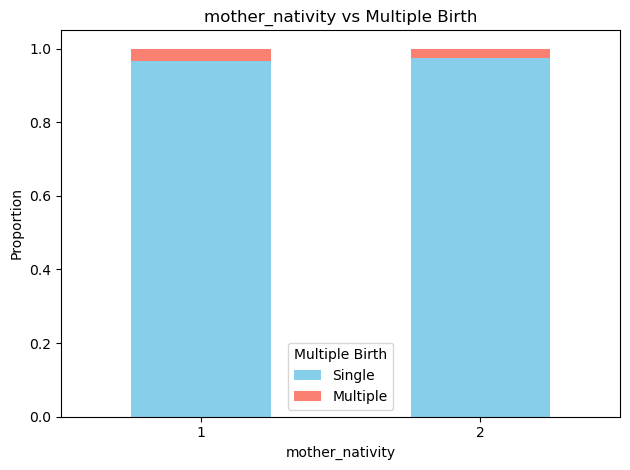

In [21]:
plot_categorical_vs_target('mother_nativity')

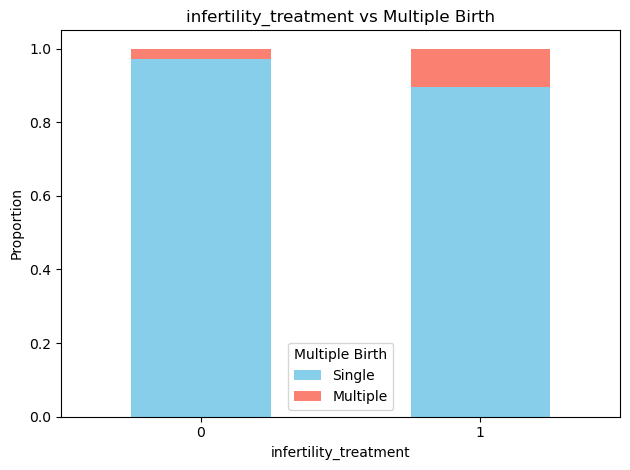

In [22]:
plot_categorical_vs_target('infertility_treatment')

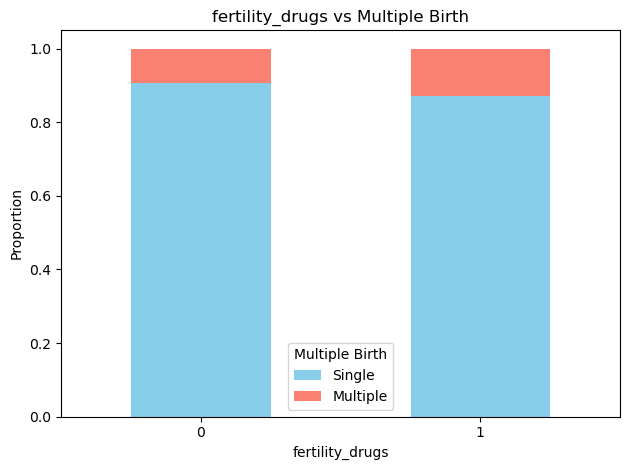

In [23]:
plot_categorical_vs_target('fertility_drugs')

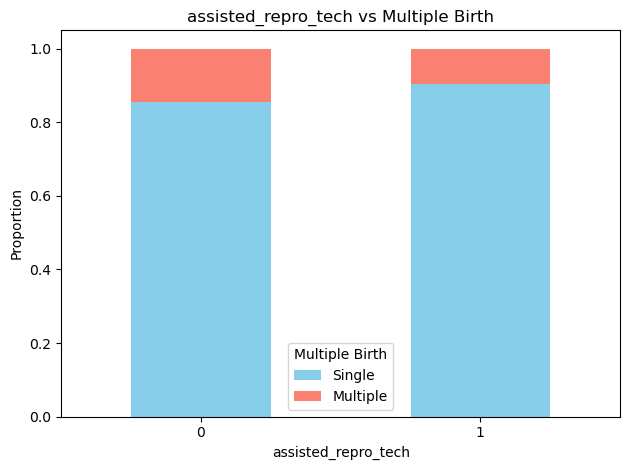

In [24]:
plot_categorical_vs_target('assisted_repro_tech')

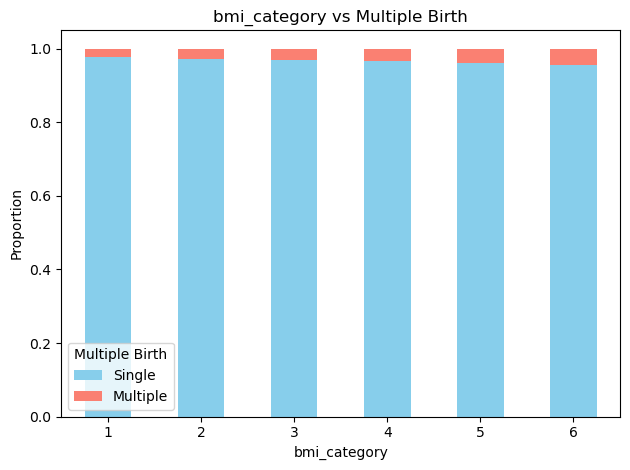

In [25]:
plot_categorical_vs_target('bmi_category')

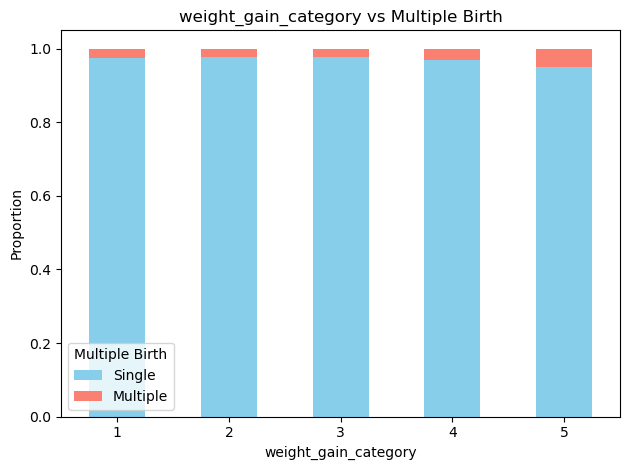

In [26]:
plot_categorical_vs_target('weight_gain_category')

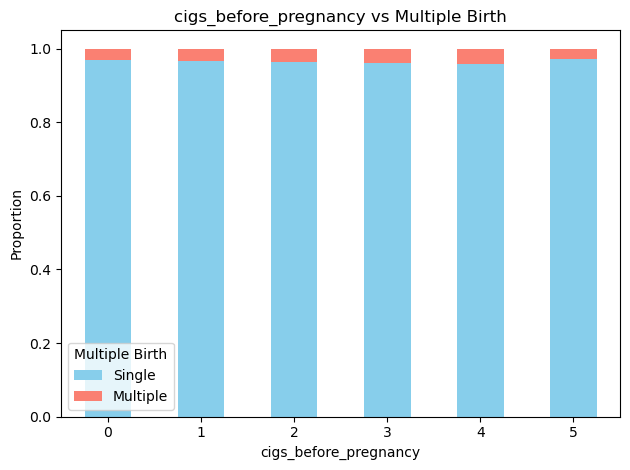

In [27]:
plot_categorical_vs_target('cigs_before_pregnancy')

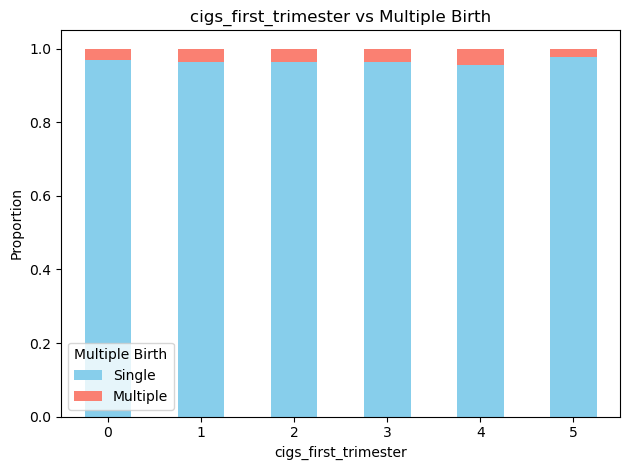

In [28]:
plot_categorical_vs_target('cigs_first_trimester')

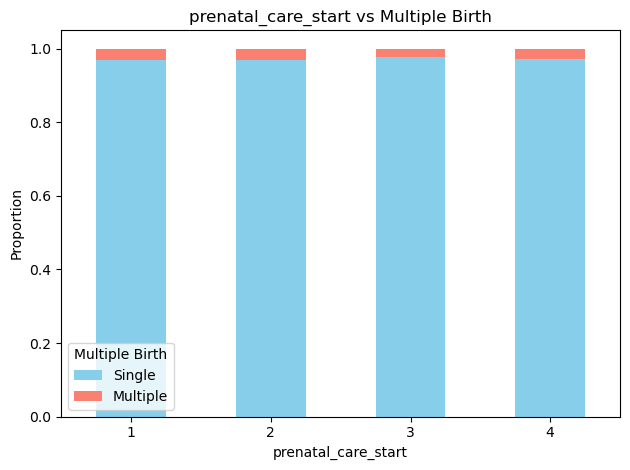

In [29]:
plot_categorical_vs_target('prenatal_care_start')

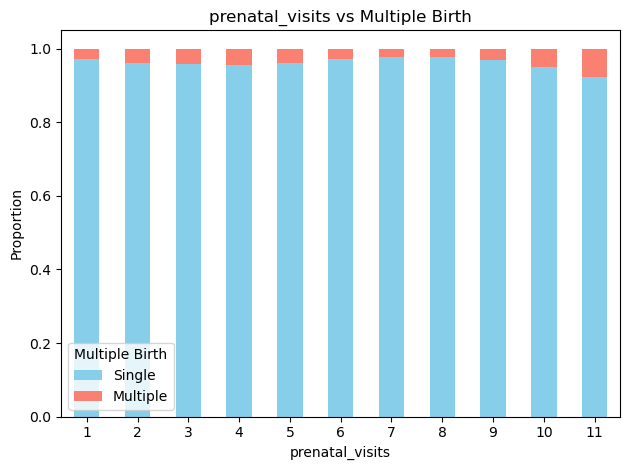

In [30]:
plot_categorical_vs_target('prenatal_visits')

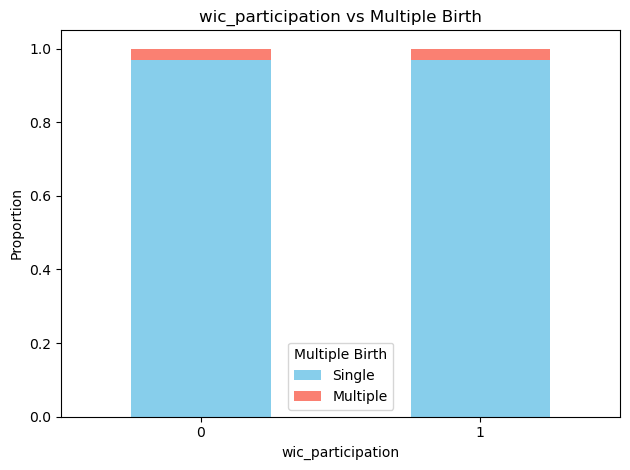

In [31]:
plot_categorical_vs_target('wic_participation')

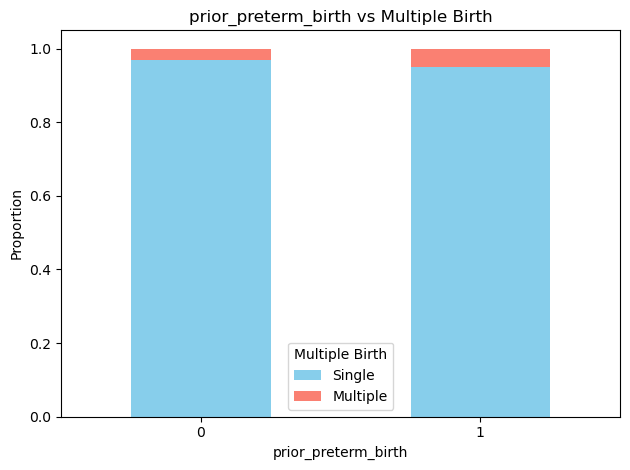

In [32]:
plot_categorical_vs_target('prior_preterm_birth')

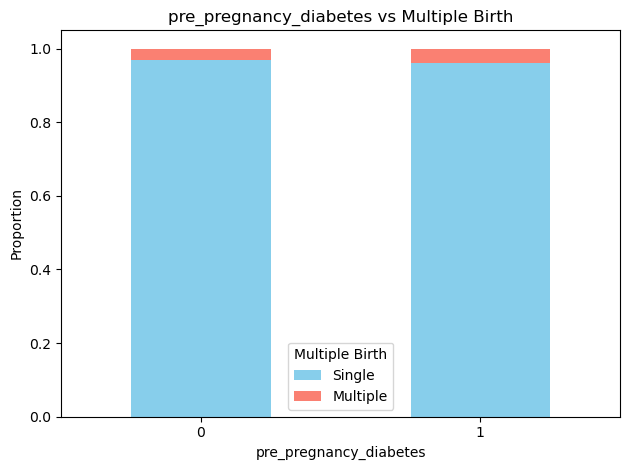

In [33]:
plot_categorical_vs_target('pre_pregnancy_diabetes')

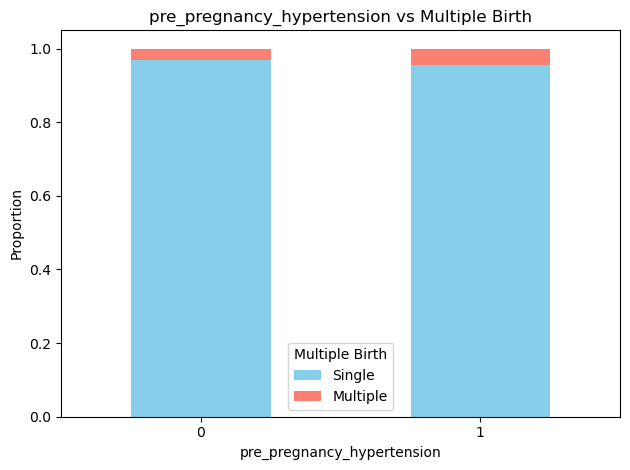

In [34]:
plot_categorical_vs_target('pre_pregnancy_hypertension')

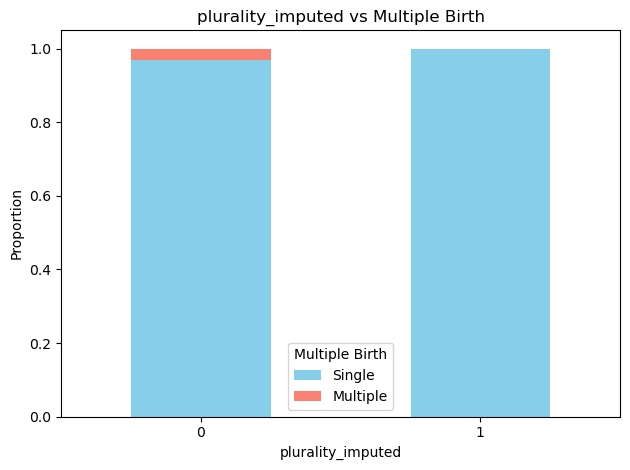

In [35]:
plot_categorical_vs_target('plurality_imputed')

In [36]:
# Create reusable function to plot the proportion of multiple vs single births by numeric variables
def plot_numeric_vs_target(feature):
    sns.boxplot(data=df, x='multiple_birth', y=feature)
    plt.title(f"{feature} by Birth Type")
    plt.xticks([0, 1], ['Single', 'Multiple'])
    plt.xlabel('Birth Type')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

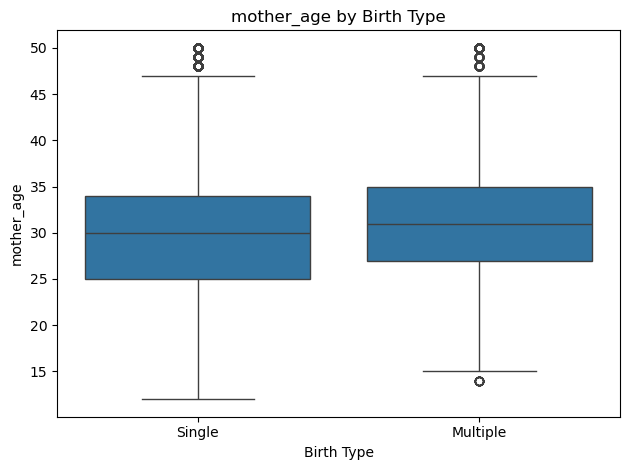

In [37]:
plot_numeric_vs_target('mother_age')

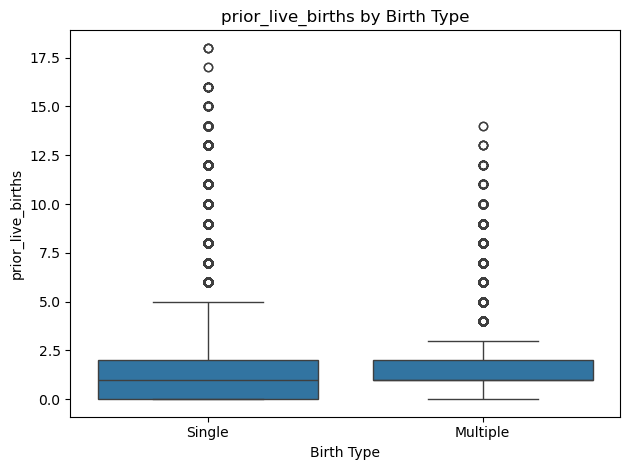

In [38]:
plot_numeric_vs_target('prior_live_births')

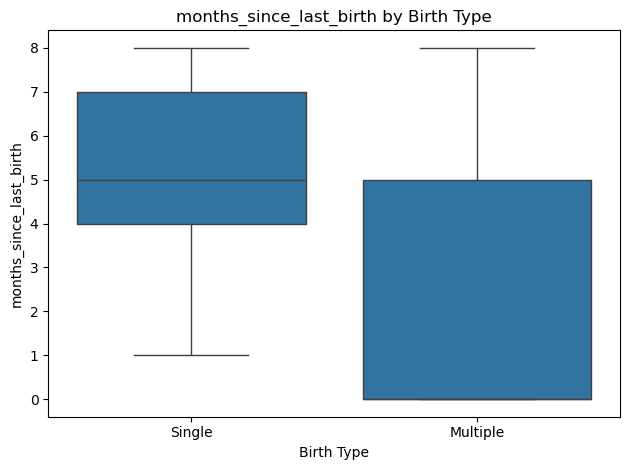

In [39]:
plot_numeric_vs_target('months_since_last_birth')

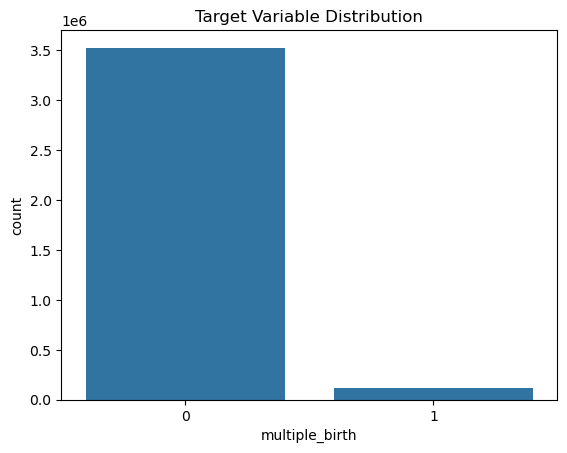

,proportion
multiple_birth,
0,0.969199
1,0.030801


In [40]:
sns.countplot(x=df['multiple_birth'])
plt.title("Target Variable Distribution")
plt.show()

# Numeric breakdown
df['multiple_birth'].value_counts(normalize=True).to_frame(name='proportion')

**Drop duplicates**

In [42]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141461 entries, 0 to 3638435
Data columns (total 20 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1141461 non-null  int64
 1   mother_nativity             1134190 non-null  Int64
 2   prior_live_births           1135079 non-null  Int64
 3   months_since_last_birth     901768 non-null   Int64
 4   infertility_treatment       1136451 non-null  Int64
 5   fertility_drugs             56245 non-null    Int64
 6   assisted_repro_tech         56245 non-null    Int64
 7   bmi_category                1091922 non-null  Int64
 8   weight_gain_category        1077924 non-null  Int64
 9   cigs_before_pregnancy       1126286 non-null  Int64
 10  cigs_first_trimester        1126513 non-null  Int64
 11  prenatal_care_start         1101400 non-null  Int64
 12  prenatal_visits             1104563 non-null  Int64
 13  wic_participation           1107

**Drop unnecessary columns**

In [44]:
# dropping unnecessary columns

df.drop(columns=['plurality', 'plurality_imputed'], inplace=True)

In [45]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)


Missing Values:
fertility_drugs               1085216
assisted_repro_tech           1085216
months_since_last_birth        239693
weight_gain_category            63537
bmi_category                    49539
prenatal_care_start             40061
prenatal_visits                 36898
wic_participation               33646
cigs_before_pregnancy           15175
cigs_first_trimester            14948
mother_nativity                  7271
prior_live_births                6382
pre_pregnancy_hypertension       5010
infertility_treatment            5010
prior_preterm_birth              5010
pre_pregnancy_diabetes           5010
mother_age                          0
multiple_birth                      0
dtype: int64


**Fill missing values**

In [47]:
# Numeric columns: use median since it is more robust to outliers
numeric_features = [
    'mother_age',
    'prior_live_births',
    'months_since_last_birth'
]
for col in numeric_features:
    df[col] = df[col].fillna(df[col].median())

# Categorical columns: use mode
categorical_features = [
    'mother_nativity',
    'infertility_treatment',
    'fertility_drugs',
    'assisted_repro_tech',
    'bmi_category',
    'weight_gain_category',
    'cigs_before_pregnancy',
    'cigs_first_trimester',
    'prenatal_care_start',
    'prenatal_visits',
    'wic_participation',
    'prior_preterm_birth',
    'pre_pregnancy_diabetes',
    'pre_pregnancy_hypertension',
]
for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

In [48]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)

Missing Values:
mother_age                    0
mother_nativity               0
pre_pregnancy_hypertension    0
pre_pregnancy_diabetes        0
prior_preterm_birth           0
wic_participation             0
prenatal_visits               0
prenatal_care_start           0
cigs_first_trimester          0
cigs_before_pregnancy         0
weight_gain_category          0
bmi_category                  0
assisted_repro_tech           0
fertility_drugs               0
infertility_treatment         0
months_since_last_birth       0
prior_live_births             0
multiple_birth                0
dtype: int64


**Outliers Analizys**

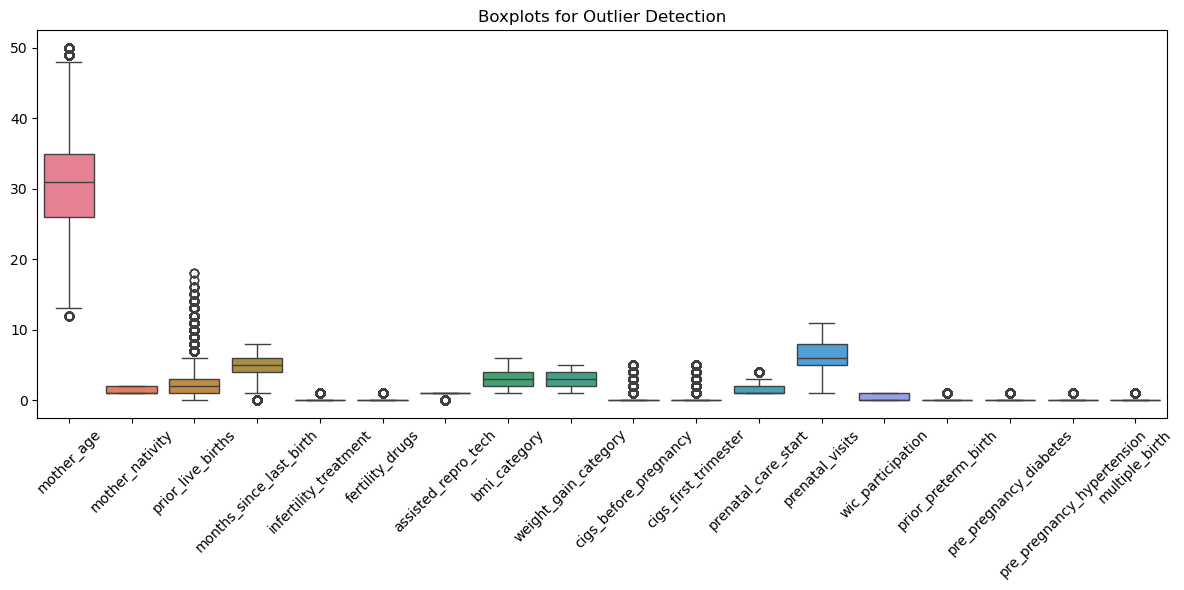

In [50]:

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Cap outliers** Using winsorization in order to maintain data points
Instead of removing outliers, cap them using 1st–99th percentile

In [52]:
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    return df

numeric_cols = df.select_dtypes(include='number').columns.tolist()
df = cap_outliers(df, numeric_cols)

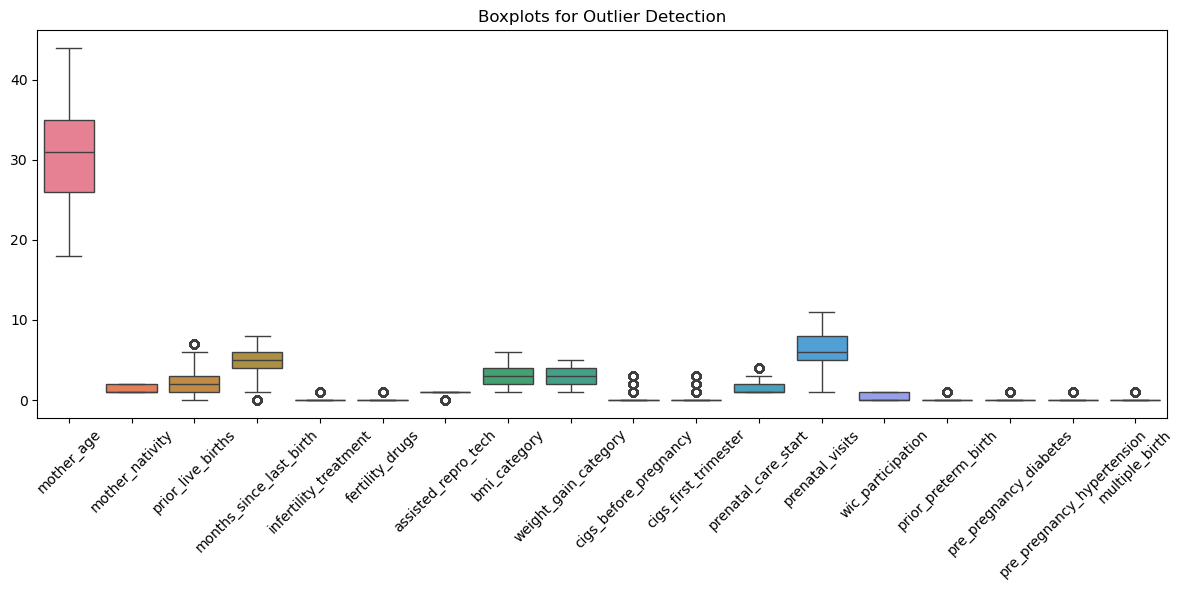

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feature Encoding

In [55]:
# One-hot encode 'mother_nativity' (3 categories: 1, 2, 3)
df = pd.get_dummies(df, columns=['mother_nativity'], prefix='mother_nativity', drop_first=True)

# Check that all remaining columns are numeric
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print("Non-numeric columns remaining:", non_numeric_cols)

Non-numeric columns remaining: ['mother_nativity_2']


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141461 entries, 0 to 3638435
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1141461 non-null  int64
 1   prior_live_births           1141461 non-null  Int64
 2   months_since_last_birth     1141461 non-null  Int64
 3   infertility_treatment       1141461 non-null  Int64
 4   fertility_drugs             1141461 non-null  Int64
 5   assisted_repro_tech         1141461 non-null  Int64
 6   bmi_category                1141461 non-null  Int64
 7   weight_gain_category        1141461 non-null  Int64
 8   cigs_before_pregnancy       1141461 non-null  Int64
 9   cigs_first_trimester        1141461 non-null  Int64
 10  prenatal_care_start         1141461 non-null  Int64
 11  prenatal_visits             1141461 non-null  Int64
 12  wic_participation           1141461 non-null  Int64
 13  prior_preterm_birth         1141

In [57]:
# casting boolean variable to integer
df['mother_nativity_2'] = df['mother_nativity_2'].astype('Int64')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141461 entries, 0 to 3638435
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1141461 non-null  int64
 1   prior_live_births           1141461 non-null  Int64
 2   months_since_last_birth     1141461 non-null  Int64
 3   infertility_treatment       1141461 non-null  Int64
 4   fertility_drugs             1141461 non-null  Int64
 5   assisted_repro_tech         1141461 non-null  Int64
 6   bmi_category                1141461 non-null  Int64
 7   weight_gain_category        1141461 non-null  Int64
 8   cigs_before_pregnancy       1141461 non-null  Int64
 9   cigs_first_trimester        1141461 non-null  Int64
 10  prenatal_care_start         1141461 non-null  Int64
 11  prenatal_visits             1141461 non-null  Int64
 12  wic_participation           1141461 non-null  Int64
 13  prior_preterm_birth         1141

#### Data Setup

**Split Train/Test Data**

In [61]:
X = df.drop(columns=['multiple_birth'])
y = df['multiple_birth']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### Model Training

For model training, I began by establishing a simple logistic regression baseline to understand initial performance and identify the impact of class imbalance. To improve results, I evaluated feature importance and removed variables that negatively affected performance, then retrained the model using only the most relevant features. To further address the imbalance in the target variable, I applied SMOTE to the training data, which significantly improved recall for the minority class. Building on this, I trained additional models using the same refined feature set and resampled data, comparing their performance to identify the most effective approach. Finally, I applied hyperparameter tuning using GridSearchCV to optimize the best-performing model and enhance its generalization capability.


**Baseline: Logistic Regression**

In [64]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluation 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97    212171
           1       0.98      0.14      0.24     16122

    accuracy                           0.94    228293
   macro avg       0.96      0.57      0.61    228293
weighted avg       0.94      0.94      0.92    228293

[[212124     47]
 [ 13879   2243]]


**Feature Selection** using SequentialFeatureSelector in order to remove the features that negatively impacted performance.

In [66]:

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sfs = SequentialFeatureSelector(estimator=LogisticRegression(),
                                    n_features_to_select='auto',
                                    cv = 5)
sfs.fit(X_train_scaled, y_train)

X_train_selected_scaled = sfs.transform(X_train_scaled)
X_test_selected_scaled = sfs.transform(X_test_scaled)



**Logistic Regression with Selected Features**

In [68]:
# No need to scale since features were scaled before SFS

model = LogisticRegression()
model.fit(X_train_selected_scaled, y_train)


y_pred = model.predict(X_test_selected_scaled)

# Evaluation 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    212171
           1       0.99      0.14      0.24     16122

    accuracy                           0.94    228293
   macro avg       0.96      0.57      0.60    228293
weighted avg       0.94      0.94      0.92    228293

[[212139     32]
 [ 13919   2203]]


**Resampling with SMOTE**

In [70]:
# Use the same selected columns on the RAW (unscaled) training data

X_train = X_train.astype('float')

selected_columns = sfs.get_support(indices=True)
X_train_selected_unscaled = X_train.iloc[:, selected_columns]

# Apply SMOTE to selected unscaled data
smote = SMOTE(random_state=42)
X_train_selected_resampled, y_train_resampled = smote.fit_resample(X_train_selected_unscaled, y_train)


**Logistic Regression with Feature Selection and Resampling**

In [72]:
scaler = StandardScaler()
X_train_selected_resampled_scaled = scaler.fit_transform(X_train_selected_resampled)

X_test_selected = X_test.iloc[:, selected_columns]
X_test_selected_scaled = scaler.transform(X_test_selected)

model = LogisticRegression()
model.fit(X_train_selected_resampled_scaled, y_train_resampled)

y_pred = model.predict(X_test_selected_scaled)

# Evaluation 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81    212171
           1       0.15      0.68      0.24     16122

    accuracy                           0.70    228293
   macro avg       0.56      0.69      0.53    228293
weighted avg       0.91      0.70      0.77    228293

[[148307  63864]
 [  5227  10895]]


**Random Forest with Feature Selection and Resampling**

In [74]:
X_test_selected = X_test.iloc[:, selected_columns]

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_selected_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_selected)

# Evaluation 
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90    212171
           1       0.23      0.63      0.34     16122

    accuracy                           0.82    228293
   macro avg       0.60      0.74      0.62    228293
weighted avg       0.92      0.82      0.86    228293

[[178106  34065]
 [  5919  10203]]


**XGBoost Classifier with Feature Selection and Resampling**

In [76]:
# Estimate scale_pos_weight: ratio of majority to minority class
scale_pos_weight = np.bincount(y_train_resampled)[0] / np.bincount(y_train_resampled)[1]

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_selected_resampled, y_train_resampled)

y_pred_xgb = rf_model.predict(X_test_selected)

# Evaluation 
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90    212171
           1       0.23      0.63      0.34     16122

    accuracy                           0.82    228293
   macro avg       0.60      0.74      0.62    228293
weighted avg       0.92      0.82      0.86    228293

[[178106  34065]
 [  5919  10203]]


**LightGBMClassifier with Feature Selection and Resampling**

In [78]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_selected_resampled, y_train_resampled)

y_pred_lgb = lgb_model.predict(X_test_selected)

# Evaluation 
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

[LightGBM] [Info] Number of positive: 848678, number of negative: 848678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1697356, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.97      0.84      0.90    212171
           1       0.23      0.63      0.34     16122

    accuracy                           0.82    228293
   macro avg       0.60      0.74      0.62    228293
weighted avg       0.92      0.82      0.86    228293

[[178106  34065]
 [  5919  10203]]


**Pipeline with SMOTE + XGBoost + GridSearchCV**

In [92]:

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.01, 0.1]
}

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    212171
           1       1.00      0.41      0.59     16122

    accuracy                           0.96    228293
   macro avg       0.98      0.71      0.78    228293
weighted avg       0.96      0.96      0.95    228293

[[212171      0]
 [  9447   6675]]


**Visualizing XGBoost Feature Importance**

In [98]:
from xgboost import plot_importance


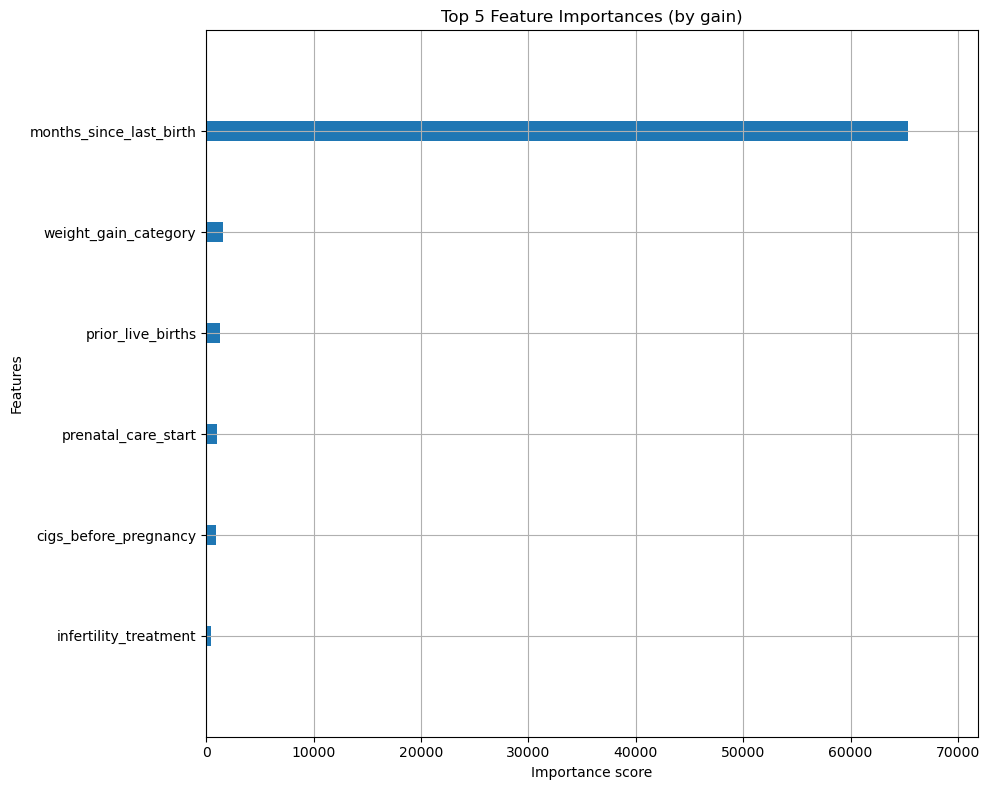

In [104]:

xgb_clf = grid_search.best_estimator_.named_steps['xgb']
booster = xgb_clf.get_booster()

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(booster, 
                ax=ax, 
                max_num_features=10, 
                importance_type='gain',
                show_values=False)
ax.set_title("Top 5 Feature Importances (by gain)")
plt.tight_layout()
plt.show()

**Model Selection Rationale**

After evaluating six different experiments (baseline LR, LR + feature‐selection, LR + FS + SMOTE, tree-based models with SMOTE, and a fully tuned XGBoost pipeline), the **SMOTE + XGB + GridSearchCV** pipeline was chosen as the final model. It achieved:

- **Accuracy: 0.96**  
- **Precision (multiple birth): 1.00**  
- **Recall (multiple birth): 0.41**  
- **Weighted F1: 0.95**  

We prioritized **precision** and **overall F1** because in a clinical setting false positives (singletons flagged as multiples) would trigger unnecessary interventions and anxiety, and our model eliminated these entirely. Although recall is modest (we still miss ~59 % of true multiples), the high‐precision guarantee ensures that any pregnancy we flag for extra monitoring truly needs it.  
